# Relationship Between Magnitude And Multiplicity

In [199]:
import pandas as pd
import numpy as np
import datetime as dt

In [200]:
csv_file = "../datasets/All (1960-2023).csv"
usgs = pd.read_csv(csv_file, sep = ',', lineterminator='\n', dtype={'time':str})

C:\Users\Vishal\AppData\Local\Temp\ipykernel_20268\3011563604.py:2: DtypeWarning:

Columns (1,2,3,4,6,7,8,9,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.



## Data Filtering
1. Converting the date columns to datetime
2. Date > 1960-01-01 and < 2023-01-01
3. Longitude > -123 and < -113
4. Latitude > 29 and < 39

In [201]:
#filter the dataset by Date > 1960-01-01 and Date < 2023-01-1 
usgs["time"] = pd.to_datetime(usgs["time"], errors="coerce").dt.strftime("%Y-%m-%d")
usgs = usgs[(pd.to_datetime(usgs['time']) > pd.to_datetime('1960-01-01')) & (pd.to_datetime(usgs['time']) < pd.to_datetime('2023-01-01'))]

usgs['longitude'] = pd.to_numeric(usgs['longitude'], errors='coerce')
usgs['latitude'] = pd.to_numeric(usgs['latitude'], errors='coerce')
usgs['mag'] = pd.to_numeric(usgs['mag'], errors='coerce')

#filter the dataset by X > -123 and X < -113 and Y > 29 and Y < 39
usgs = usgs[usgs['longitude'] > -123]
usgs = usgs[usgs['longitude'] < -113]
usgs = usgs[usgs['latitude'] < 39]
usgs = usgs[usgs['latitude'] > 29]
usgs.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource\r
240,2022-12-31,33.397500,-116.393333,3.88,4.14,mw,132,16,0.07391,0.19,...,2023-09-22T21:50:30.029Z,"16 km N of Borrego Springs, CA",earthquake,0.1,0.38,NaN,6,reviewed,ci,ci\r
241,2022-12-31,34.355667,-116.921833,4.73,3.47,mw,121,25,0.07845,0.15,...,2023-03-07T19:00:01.040Z,"11km SSE of Lucerne Valley, CA",earthquake,0.09,0.41,NaN,4,reviewed,ci,ci\r
246,2022-12-22,37.620167,-122.025000,3.82,3.34,mw,141,16,NaN,0.16,...,2023-04-20T04:34:00.806Z,"3km N of Union City, CA",earthquake,0.1,0.17,NaN,3,reviewed,nc,nc\r
262,2022-12-17,37.918167,-122.304000,5.48,3.57,mw,170,19,0.01598,0.15,...,2023-07-27T08:15:34.318Z,"1km ENE of El Cerrito, CA",earthquake,0.1,0.17,NaN,4,reviewed,nc,nc\r
263,2022-12-13,36.604667,-121.209333,8.88,3.28,ml,67,55,0.03812,0.09,...,2023-02-18T22:04:08.040Z,"10km NW of Pinnacles, CA",earthquake,0.14,0.28,0.129,72,reviewed,nc,nc\r


In [202]:
time = []
for i in usgs['time']:
    time.append(pd.to_datetime(i))
usgs['time'] = time

## Data Grouping
Data is grouped into 1 day chunks

In [203]:
usgs_grouped_counts = pd.DataFrame(usgs.groupby(usgs['time'].dt.to_period('D')).mag.count())
usgs_grouped_counts.rename(columns={'mag':'count'}, inplace=True)

usgs_grouped_max = pd.DataFrame(usgs.groupby(usgs['time'].dt.to_period('D')).mag.max())

In [204]:
from sklearn.preprocessing import StandardScaler

## Data Scaling and Merging
Data is scaled using a Standard Scaler and merged

In [205]:
scaler = StandardScaler()

x_vals = np.array(usgs_grouped_counts["count"]).reshape(-1,1)
scaled_counts_arr = scaler.fit_transform(x_vals)

x_vals = np.array(usgs_grouped_max["mag"]).reshape(-1,1)
scaled_max_arr = scaler.fit_transform(x_vals)

In [206]:
merged_earthquake_data = usgs_grouped_counts.copy()
merged_earthquake_data['count'] = scaled_counts_arr
merged_earthquake_data['mag'] = scaled_max_arr
merged_earthquake_data = merged_earthquake_data.reset_index()
merged_earthquake_data.head()

,time,count,mag
0,1960-01-02,-0.163205,0.874222
1,1960-01-05,-0.163205,-0.985942
2,1960-01-07,-0.163205,0.137524
3,1960-01-08,-0.163205,-0.857020
4,1960-01-11,-0.163205,0.413786


In [207]:
import plotly.express as px
import plotly.graph_objects as go

In [208]:
merged_earthquake_data['time'] = merged_earthquake_data['time'].dt.to_timestamp()

fig = px.line(merged_earthquake_data, x='time', y=['count', 'mag'], labels={'value': 'Value'}, title='Scaled Earthquake Magnitude vs Multiplicity')
fig.update_layout(
    width=900,
    height=600,
)

fig.update_traces(line=dict(width=1.0))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(dragmode='pan')

fig.show()

Now we find the 10 largest values of both dataframes

In [209]:
scaled_earthquake_count = merged_earthquake_data.copy()
scaled_earthquake_count = scaled_earthquake_count.nlargest(15, 'scaled_earthquake_count')
scaled_earthquake_count.head(15)

KeyError: 'scaled_earthquake_count'

Text(0, 0.5, 'Normalized Earthquake Magnitudes (Top 15)')

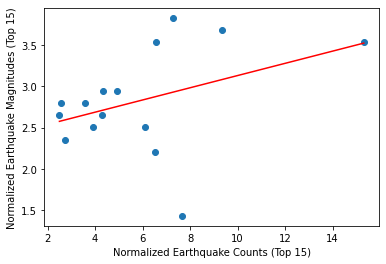

In [ ]:
plt.scatter(scaled_earthquake_count['scaled_earthquake_count'], scaled_earthquake_count['scaled_max_mag'])
slope, intercept = np.polyfit(scaled_earthquake_count['scaled_earthquake_count'], scaled_earthquake_count['scaled_max_mag'], 1)  # 1 specifies a linear fit

# Create the best-fit line equation
best_fit_line = slope * np.array(scaled_earthquake_count['scaled_earthquake_count']) + intercept

# Plot the best-fit line
plt.plot(scaled_earthquake_count['scaled_earthquake_count'], best_fit_line, color='red', label='Line of Best Fit')
plt.xlabel('Normalized Earthquake Counts (Top 15)')
plt.ylabel('Normalized Earthquake Magnitudes (Top 15)')

In [ ]:
scaled_max_mag = merged_earthquake_data.copy()
scaled_max_mag = scaled_max_mag.nlargest(15, 'scaled_max_mag')
scaled_max_mag.head(15)

,Date,scaled_earthquake_count,scaled_max_mag
389,1992-06-01,7.287419,3.830622
603,2010-04-01,9.327743,3.682940
477,1999-10-01,6.562956,3.535257
714,2019-07-01,15.315650,3.535257
357,1989-10-01,2.423168,3.239892
280,1983-05-01,4.345213,2.944527
408,1994-01-01,4.907041,2.944527
99,1968-04-01,1.151662,2.796845
133,1971-02-01,3.561610,2.796845
334,1987-11-01,2.571018,2.796845


In [ ]:
earthquake_count_dates = np.array(scaled_earthquake_count["Date"])
max_mag_dates = np.array(scaled_max_mag["Date"])

In [ ]:
def jaccard_similarity(a, b):
    intersection = len(set(a).intersection(b))
    union = len(set(a).union(b))
    similarity = intersection / union
    percent_similarity = similarity * 100
    return percent_similarity

print(jaccard_similarity(earthquake_count_dates, max_mag_dates))

66.66666666666666


explain what 2/3rds jaccard similarity means